## Greenhouse Plant Growth Prediction
Muh Amri Sidiq

## Introduction
The integration of advanced technology in agriculture has revolutionized traditional cultivation practices, particularly in controlled environments like greenhouses. The "Greenhouse Plant Growth" study investigates the physiological and morphological development of plants under two distinct greenhouse settings an IoT enabled system and a conventional manual setup at the Agriculture Lab of Tikrit University. This research leverages The Advanced IoT Agriculture Dataset, compiled by Mohammed Ismail Lifta (2023–2024) under the guidance of Prof. Wisam Dawood Abdullah, which provides comprehensive plant growth measurements captured across both environments.

Spanning 30,000 records and 14 variables, the dataset offers detailed insights into plant chlorophyll levels, height growth rates, biomass (wet and dry weights), root structure, and other key physiological attributes. Data was collected from randomized plant batches (R1–R3) to ensure unbiased representation across different stages of growth and environmental conditions. The IoT greenhouse employed real-time sensors to monitor plant metrics, while the traditional greenhouse followed standard manual sampling protocols.

Each record in the dataset is labeled with a categorical class (e.g., SA, SB, SC, TA, TB, TC) that indicates the experimental group, allowing for advanced analytical applications. These include machine learning tasks such as classification of treatment types, regression-based growth prediction, and physiological correlation studies particularly between chlorophyll content, root and leaf metrics, and dry matter composition.

This dataset not only supports scientific research in environmental and agricultural sciences but also provides a valuable resource for data-driven modeling and smart farming innovations.

## Install Library

In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import shap
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Import, Read Data & Understanding

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/greenhouse-plant-growth-metrics")

print("Path to dataset files:", path)

100%|██████████| 2.90M/2.90M [00:00<00:00, 113MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/adilshamim8/greenhouse-plant-growth-metrics/versions/1


In [3]:
# List files in the downloaded dataset folder
for file in os.listdir(path):
    print(file)

file_path = os.path.join(path, 'Greenhouse Plant Growth Metrics.csv')

greenhouse = pd.read_csv(file_path)

Greenhouse Plant Growth Metrics.csv


check preview data

In [4]:
greenhouse.head()

,Random,ACHP,PHR,AWWGV,ALAP,ANPL,ARD,ADWR,PDMVG,ARL,AWWR,ADWV,PDMRG,Class
0,R1,34.533468,54.566983,1.147449,1284.229549,4.999713,16.274918,1.706810,18.399982,19.739037,2.949240,0.209251,57.633906,SA
1,R1,34.489028,54.567692,1.149530,1284.247744,5.024259,16.269452,1.700930,18.398289,19.758836,2.943137,0.216154,57.633697,SA
2,R2,33.100405,67.067344,1.104647,1009.208996,5.007652,15.980760,1.185391,19.398789,20.840822,2.861635,0.200113,41.289875,SA
3,R1,34.498319,54.559049,1.137759,1284.227623,4.991501,16.276710,1.716396,18.413613,19.736098,2.946784,0.223092,57.645661,SA
4,R3,36.297008,45.588894,1.363205,981.470310,4.003682,16.979894,0.777428,31.423772,17.331894,2.766242,0.424172,27.898619,SA


Check structure data

In [5]:
greenhouse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Random  30000 non-null  object 
 1   ACHP    30000 non-null  float64
 2   PHR     30000 non-null  float64
 3   AWWGV   30000 non-null  float64
 4   ALAP    30000 non-null  float64
 5   ANPL    30000 non-null  float64
 6   ARD     30000 non-null  float64
 7   ADWR    30000 non-null  float64
 8   PDMVG   30000 non-null  float64
 9   ARL     30000 non-null  float64
 10  AWWR    30000 non-null  float64
 11  ADWV    30000 non-null  float64
 12  PDMRG   30000 non-null  float64
 13  Class   30000 non-null  object 
dtypes: float64(12), object(2)
memory usage: 3.2+ MB


We have 30.000 row and 14 column with no missing values. explain data this bellow:

 - Random: Identifier representing different plant sample batches (e.g., R1, R2, R3).
 - ACHP: Average chlorophyll content per plant, an indicator of photosynthetic activity.
 - PHR: Plant height rate – measures the vertical growth over time.
 - AWWGV: Average wet weight of vegetative growth – total fresh weight of the above-ground parts.
 - ALAP: Average leaf area per plant – surface area of leaves which impacts photosynthesis.
 - ANPL: Average number of leaves per plant – indicates plant maturity and foliage density.
 - ARD: Average root diameter – thickness of roots, relevant to nutrient uptake.
 - ADWR: Average dry weight of roots – total root biomass after drying.
 - PDMVG: Percentage of dry matter in vegetative growth – measures solid content in shoots.
 - ARL: Average root length – indicates root development and depth.
 - AWWR: Average wet weight of roots – total fresh root weight.
 - ADWV: Average dry weight of vegetative parts – dried mass of above-ground plant parts.
 - PDMRG: Percentage of dry matter in root growth – solid content of the root system.
 - Class: Categorical label indicating the experimental group: SA, SB, SC (Traditional Greenhouse), TA, TB, TC (IoT-based Greenhouse).

## Exploratory Data Analysis

In [6]:
greenhouse.describe()

,ACHP,PHR,AWWGV,ALAP,ANPL,ARD,ADWR,PDMVG,ARL,AWWR,ADWV,PDMRG
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,38.060575,59.020331,1.247257,1063.639833,3.944789,16.285792,1.000981,22.674553,18.071061,2.907011,0.292094,34.922184
std,4.441682,11.985213,0.245989,260.712823,0.702537,2.882793,0.456292,9.571091,2.932830,1.361928,0.151516,7.998132
min,32.664004,37.020398,0.848351,658.488225,2.959173,11.075737,0.241972,8.021505,12.359924,1.126715,0.038210,23.632527
25%,34.399604,51.059436,1.064865,875.501356,3.013099,13.933350,0.675892,14.980983,15.600294,1.911408,0.185512,28.650713
50%,36.575753,55.912058,1.211328,1009.249081,3.998577,16.248496,0.833799,21.954006,18.477019,2.818611,0.246454,33.372665
75%,42.300836,67.069465,1.501692,1243.866525,4.015829,18.202577,1.313504,27.711471,20.365252,3.254133,0.407858,39.137224
max,46.431668,77.040610,1.775383,1751.031654,5.037358,23.325870,2.196556,43.660373,23.253049,6.908923,0.687470,57.672004


Varian range all data

In [7]:
greenhouse.describe(include='object')

,Random,Class
count,30000,30000
unique,3,6
top,R1,SA
freq,10045,5000


In [8]:
greenhouse.duplicated().sum()

np.int64(0)

No duplicated data

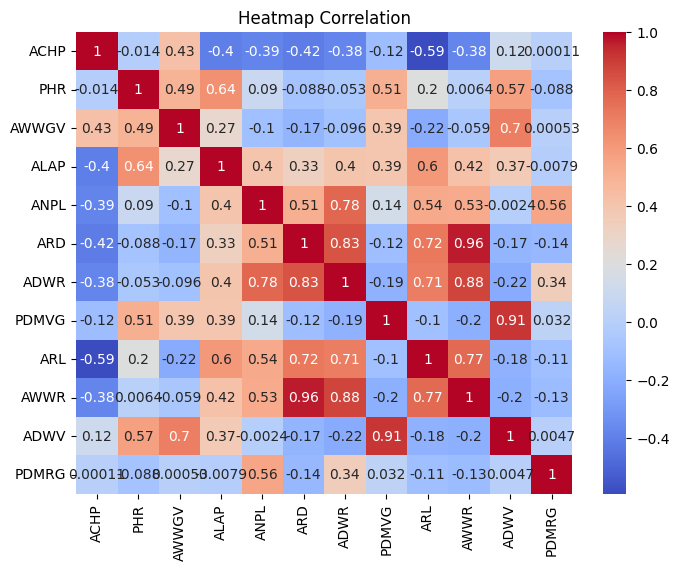

In [9]:
greenhouse_numeric = greenhouse.select_dtypes(include='number')

corr = greenhouse_numeric.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Correlation")
plt.show()

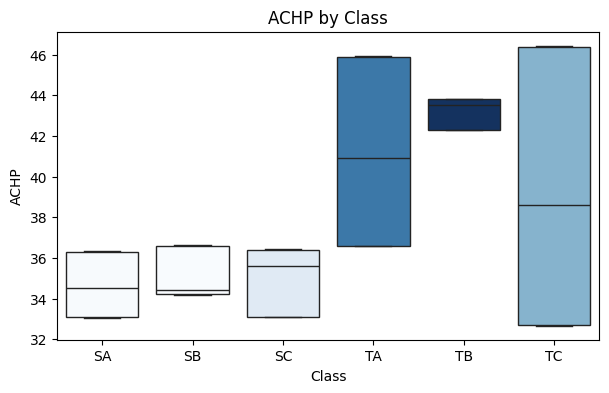

In [12]:
medians_achp = greenhouse.groupby("Class")["ACHP"].median()

norm_achp = plt.Normalize(medians_achp.min(), medians_achp.max())
colors_achp = cm.Blues(norm_achp(medians_achp.values))

palette_achp = dict(zip(medians_achp.index, colors_achp))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='ACHP', data=greenhouse, palette=palette_achp)
plt.title('ACHP by Class')
plt.xlabel('Class')
plt.ylabel('ACHP')
plt.show()

Insight: `Class` TB have highest median `ACHP` and `Class` TC have more wide quirtile `ACHP` than others

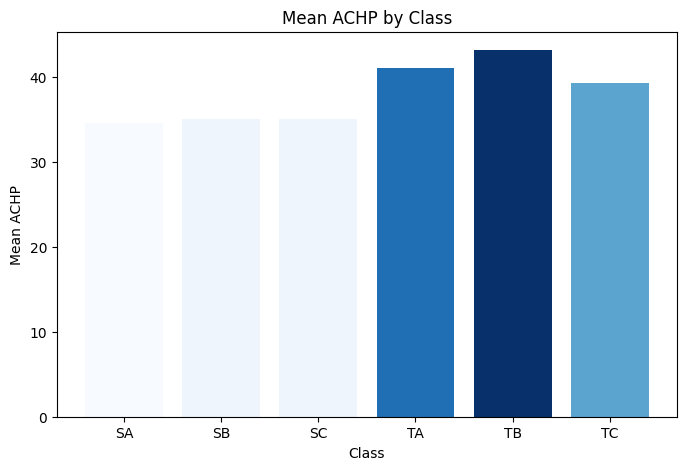

In [13]:
means_achp = greenhouse.groupby('Class')['ACHP'].mean().reset_index()

norm_achp = plt.Normalize(means_achp['ACHP'].min(), means_achp['ACHP'].max())
colors_achp = cm.Blues(norm_achp(means_achp['ACHP']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_achp['Class'], means_achp['ACHP'], color=colors_achp)
plt.title('Mean ACHP by Class')
plt.ylabel('Mean ACHP')
plt.xlabel('Class')
plt.show()

Insight: `Class` TB have mean highest `ACHP` and traditional greenhouse `Class` (SA,SB and SC) almost same mean `ACHP`

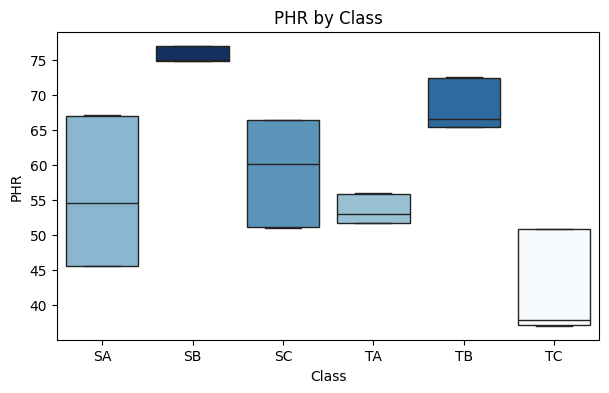

In [14]:
medians_phr = greenhouse.groupby("Class")["PHR"].median()

norm_phr = plt.Normalize(medians_phr.min(), medians_phr.max())
colors_phr = cm.Blues(norm_phr(medians_phr.values))

palette_phr = dict(zip(medians_phr.index, colors_phr))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='PHR', data=greenhouse, palette=palette_phr)
plt.title('PHR by Class')
plt.xlabel('Class')
plt.ylabel('PHR')
plt.show()

Insight: `Class` SB have median highest `PHR` and `Class` TC have lowest median `PHR`

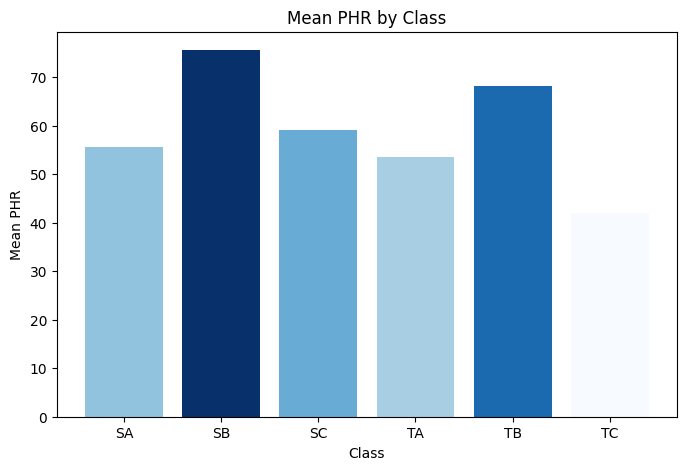

In [15]:
means_phr = greenhouse.groupby('Class')['PHR'].mean().reset_index()

norm_phr = plt.Normalize(means_phr['PHR'].min(), means_phr['PHR'].max())
colors_phr = cm.Blues(norm_phr(means_phr['PHR']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_phr['Class'], means_phr['PHR'], color=colors_phr)
plt.title('Mean PHR by Class')
plt.ylabel('Mean PHR')
plt.xlabel('Class')
plt.show()

Insight: `Class` SB have highest mean `PHR`

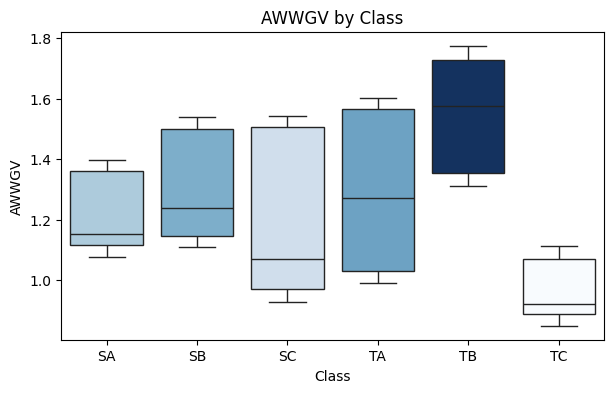

In [16]:
medians_awwgv = greenhouse.groupby("Class")["AWWGV"].median()

norm_awwgv = plt.Normalize(medians_awwgv.min(), medians_awwgv.max())
colors_awwgv = cm.Blues(norm_awwgv(medians_awwgv.values))

palette_awwgv = dict(zip(medians_awwgv.index, colors_awwgv))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='AWWGV', data=greenhouse, palette=palette_awwgv)
plt.title('AWWGV by Class')
plt.xlabel('Class')
plt.ylabel('AWWGV')
plt.show()

Insight: `Class` TB have median highest `AWWGV`

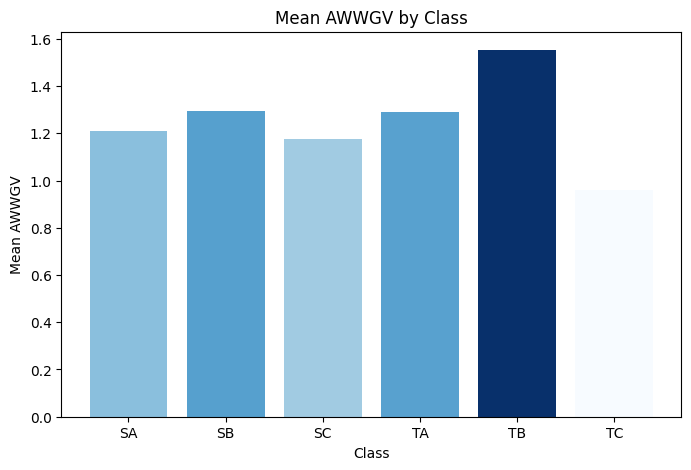

In [17]:
means_awwgv = greenhouse.groupby('Class')['AWWGV'].mean().reset_index()

norm_awwgv = plt.Normalize(means_awwgv['AWWGV'].min(), means_awwgv['AWWGV'].max())
colors_awwgv = cm.Blues(norm_awwgv(means_awwgv['AWWGV']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_awwgv['Class'], means_awwgv['AWWGV'], color=colors_awwgv)
plt.title('Mean AWWGV by Class')
plt.ylabel('Mean AWWGV')
plt.xlabel('Class')
plt.show()

Insight: `Class` TB have mean highest `AWWGV`

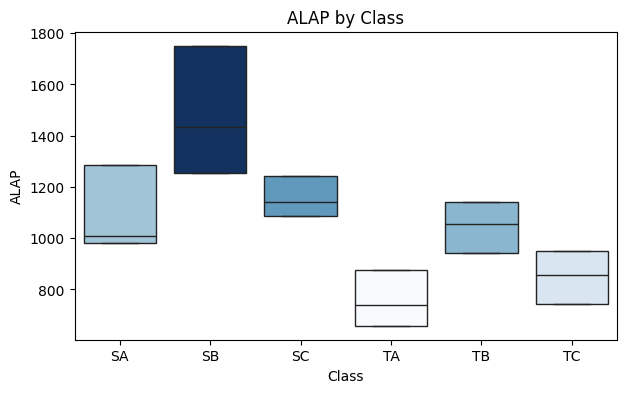

In [18]:
medians_alap = greenhouse.groupby("Class")["ALAP"].median()

norm_alap = plt.Normalize(medians_alap.min(), medians_alap.max())
colors_alap = cm.Blues(norm_alap(medians_alap.values))

palette_alap = dict(zip(medians_alap.index, colors_alap))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='ALAP', data=greenhouse, palette=palette_alap)
plt.title('ALAP by Class')
plt.xlabel('Class')
plt.ylabel('ALAP')
plt.show()

Insight: `Class` SB have median highest `ALAP` and `Class` TA have median lowest `ALAP`

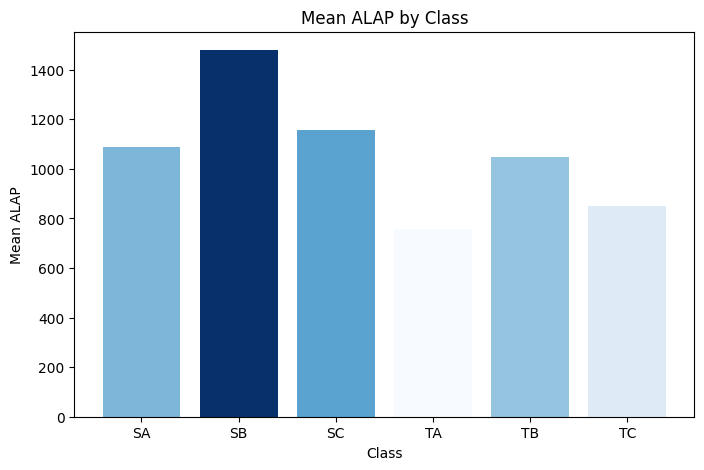

In [19]:
means_alap = greenhouse.groupby('Class')['ALAP'].mean().reset_index()

norm_alap = plt.Normalize(means_alap['ALAP'].min(), means_alap['ALAP'].max())
colors_alap = cm.Blues(norm_alap(means_alap['ALAP']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_alap['Class'], means_alap['ALAP'], color=colors_alap)
plt.title('Mean ALAP by Class')
plt.ylabel('Mean ALAP')
plt.xlabel('Class')
plt.show()

Insight: `Class` SB have mean highest `ALAP`

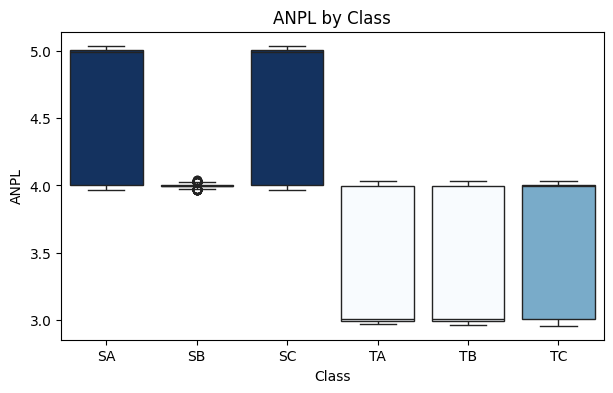

In [20]:
medians_anpl = greenhouse.groupby("Class")["ANPL"].median()

norm_anpl = plt.Normalize(medians_anpl.min(), medians_anpl.max())
colors_anpl = cm.Blues(norm_anpl(medians_anpl.values))

palette_anpl = dict(zip(medians_anpl.index, colors_anpl))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='ANPL', data=greenhouse, palette=palette_anpl)
plt.title('ANPL by Class')
plt.xlabel('Class')
plt.ylabel('ANPL')
plt.show()

Insight: `Class` SA and SC have median highest `ANPL` and `Class` TA and TB have median lowest `ANPL`

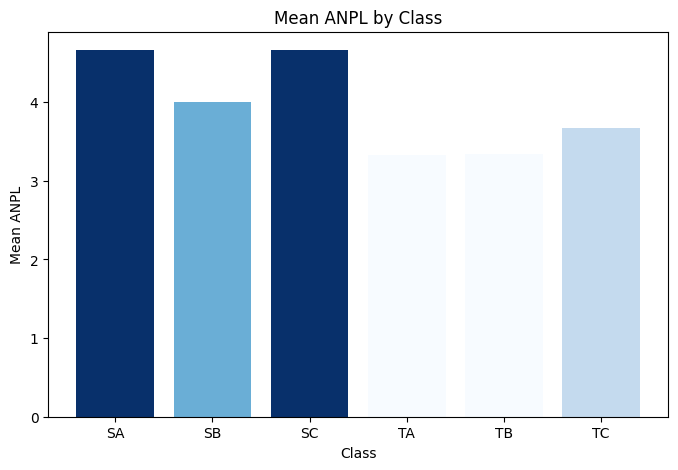

In [21]:
means_anpl = greenhouse.groupby('Class')['ANPL'].mean().reset_index()

norm_anpl = plt.Normalize(means_anpl['ANPL'].min(), means_anpl['ANPL'].max())
colors_anpl = cm.Blues(norm_anpl(means_anpl['ANPL']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_anpl['Class'], means_anpl['ANPL'], color=colors_anpl)
plt.title('Mean ANPL by Class')
plt.ylabel('Mean ANPL')
plt.xlabel('Class')
plt.show()

Insight: `Class` SA and SC have mean highest `ANPL`

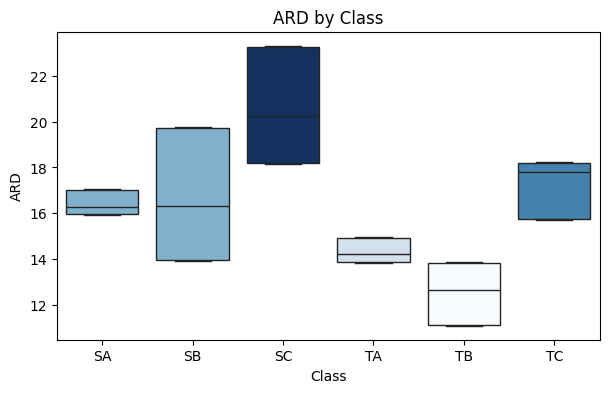

In [22]:
medians_ard = greenhouse.groupby("Class")["ARD"].median()

norm_ard = plt.Normalize(medians_ard.min(), medians_ard.max())
colors_ard = cm.Blues(norm_ard(medians_ard.values))

palette_ard = dict(zip(medians_ard.index, colors_ard))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='ARD', data=greenhouse, palette=palette_ard)
plt.title('ARD by Class')
plt.xlabel('Class')
plt.ylabel('ARD')
plt.show()

Insight: `Class` SC have median highest `ARD` and `Class` TB have median lowest `ARD`

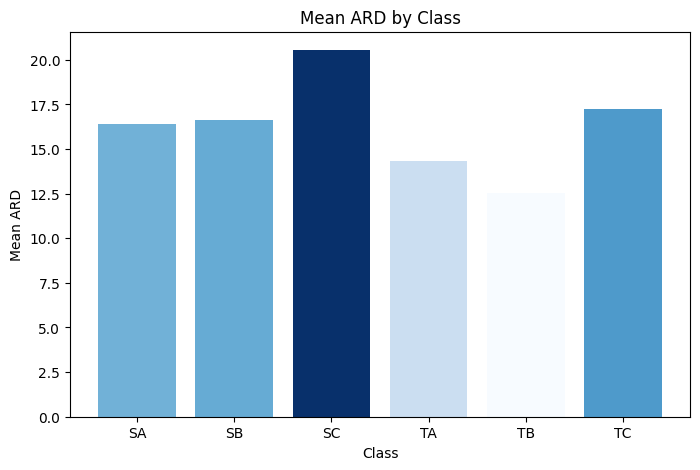

In [23]:
means_ard = greenhouse.groupby('Class')['ARD'].mean().reset_index()

norm_ard = plt.Normalize(means_ard['ARD'].min(), means_ard['ARD'].max())
colors_ard = cm.Blues(norm_ard(means_ard['ARD']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_ard['Class'], means_ard['ARD'], color=colors_ard)
plt.title('Mean ARD by Class')
plt.ylabel('Mean ARD')
plt.xlabel('Class')
plt.show()

Insight: `Class` SC have mean highest `ARD`

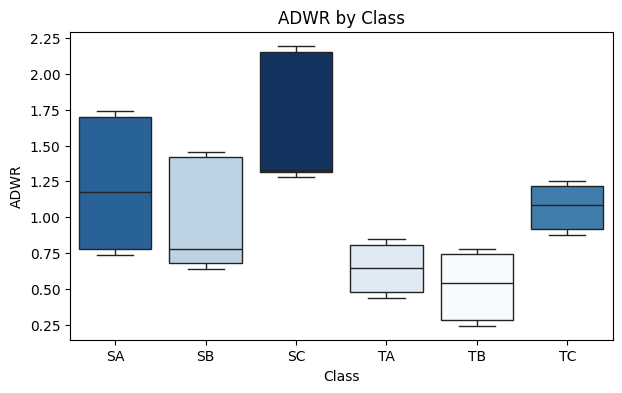

In [24]:
medians_adwr = greenhouse.groupby("Class")["ADWR"].median()

norm_adwr = plt.Normalize(medians_adwr.min(), medians_adwr.max())
colors_adwr = cm.Blues(norm_adwr(medians_adwr.values))

palette_adwr = dict(zip(medians_adwr.index, colors_adwr))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='ADWR', data=greenhouse, palette=palette_adwr)
plt.title('ADWR by Class')
plt.xlabel('Class')
plt.ylabel('ADWR')
plt.show()

Insight: `Class` SC have median highest `ADWR` and `Class` TB have median lowest `ADWR`

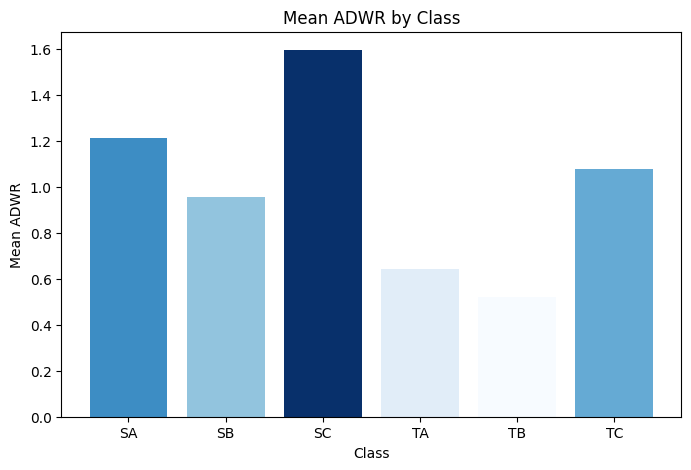

In [25]:
means_adwr = greenhouse.groupby('Class')['ADWR'].mean().reset_index()

norm_adwr = plt.Normalize(means_adwr['ADWR'].min(), means_adwr['ADWR'].max())
colors_adwr = cm.Blues(norm_adwr(means_adwr['ADWR']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_adwr['Class'], means_adwr['ADWR'], color=colors_adwr)
plt.title('Mean ADWR by Class')
plt.ylabel('Mean ADWR')
plt.xlabel('Class')
plt.show()

Insight: `Class` SC have mean highest `ADWR`

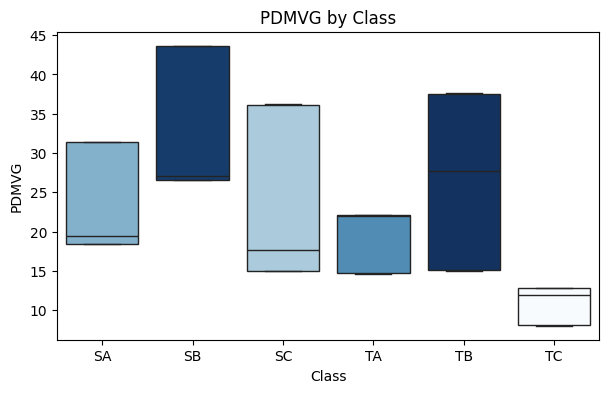

In [26]:
medians_pdmvg = greenhouse.groupby("Class")["PDMVG"].median()

norm_pdmvg = plt.Normalize(medians_pdmvg.min(), medians_pdmvg.max())
colors_pdmvg = cm.Blues(norm_pdmvg(medians_pdmvg.values))

palette_pdmvg = dict(zip(medians_pdmvg.index, colors_pdmvg))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='PDMVG', data=greenhouse, palette=palette_pdmvg)
plt.title('PDMVG by Class')
plt.xlabel('Class')
plt.ylabel('PDMVG')
plt.show()

Insight: `Class` TB have median highest `PDMVG` and `Class` TC have median lowest `PDMVG`

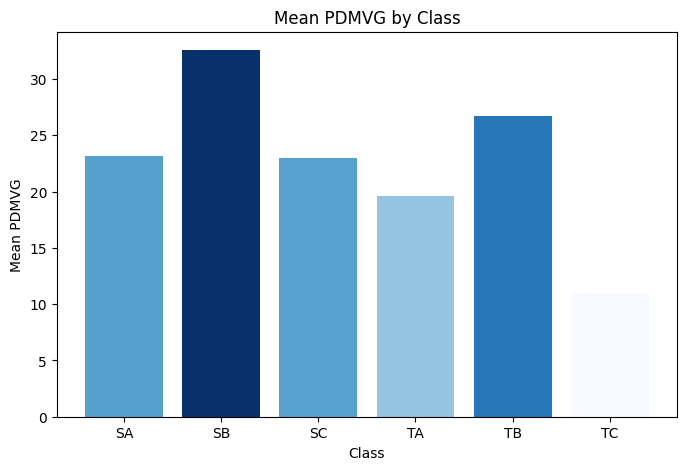

In [27]:
means_pdmvg = greenhouse.groupby('Class')['PDMVG'].mean().reset_index()

norm_pdmvg = plt.Normalize(means_pdmvg['PDMVG'].min(), means_pdmvg['PDMVG'].max())
colors_pdmvg = cm.Blues(norm_pdmvg(means_pdmvg['PDMVG']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_pdmvg['Class'], means_pdmvg['PDMVG'], color=colors_pdmvg)
plt.title('Mean PDMVG by Class')
plt.ylabel('Mean PDMVG')
plt.xlabel('Class')
plt.show()

Insight: `Class` SB have mean highest `PDMVG`

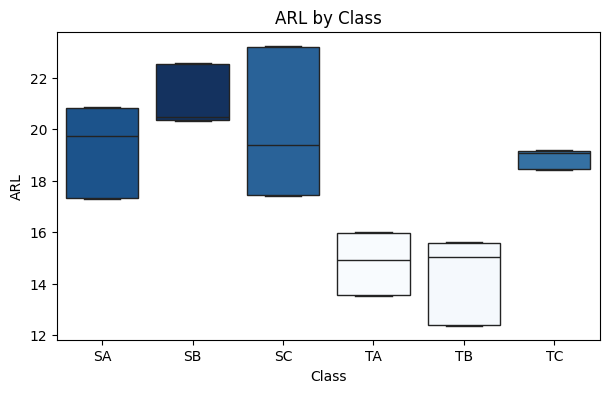

In [28]:
medians_arl = greenhouse.groupby("Class")["ARL"].median()

norm_arl = plt.Normalize(medians_arl.min(), medians_arl.max())
colors_arl = cm.Blues(norm_arl(medians_arl.values))

palette_arl = dict(zip(medians_arl.index, colors_arl))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='ARL', data=greenhouse, palette=palette_arl)
plt.title('ARL by Class')
plt.xlabel('Class')
plt.ylabel('ARL')
plt.show()

Insight: `Class` SC have median highest `ARL` and `Class` TA have median lowest `ARL`

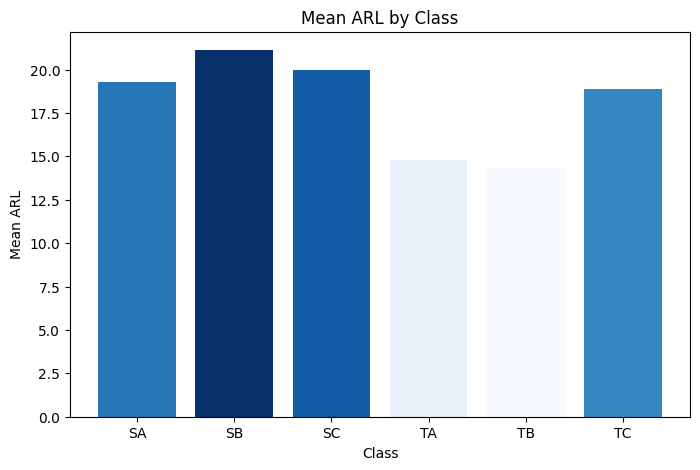

In [29]:
means_arl = greenhouse.groupby('Class')['ARL'].mean().reset_index()

norm_arl = plt.Normalize(means_arl['ARL'].min(), means_arl['ARL'].max())
colors_arl = cm.Blues(norm_arl(means_arl['ARL']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_arl['Class'], means_arl['ARL'], color=colors_arl)
plt.title('Mean ARL by Class')
plt.ylabel('Mean ARL')
plt.xlabel('Class')
plt.show()

Insight: `Class` SB have mean highest `ARL`

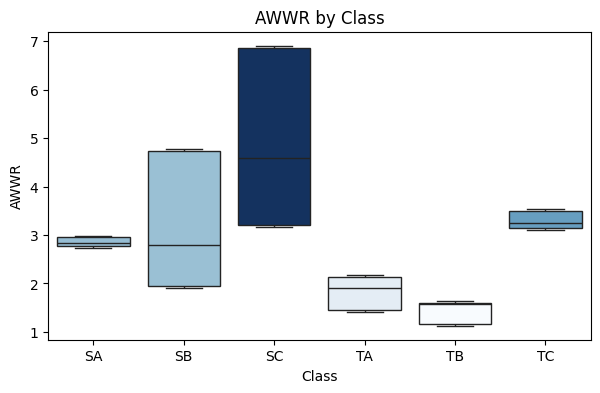

In [30]:
medians_awwr = greenhouse.groupby("Class")["AWWR"].median()

norm_awwr = plt.Normalize(medians_awwr.min(), medians_awwr.max())
colors_awwr = cm.Blues(norm_awwr(medians_awwr.values))

palette_awwr = dict(zip(medians_awwr.index, colors_awwr))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='AWWR', data=greenhouse, palette=palette_awwr)
plt.title('AWWR by Class')
plt.xlabel('Class')
plt.ylabel('AWWR')
plt.show()

Insight: `Class` SC have median highest `AWWR` and `Class` TB have median lowest `AWWR`

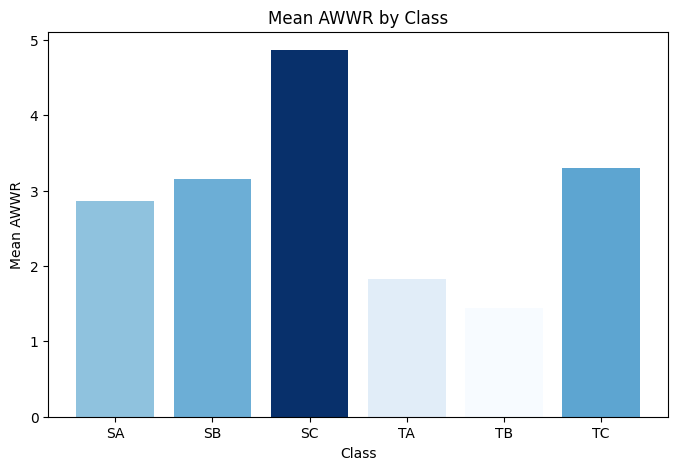

In [31]:
means_awwr = greenhouse.groupby('Class')['AWWR'].mean().reset_index()

norm_awwr = plt.Normalize(means_awwr['AWWR'].min(), means_awwr['AWWR'].max())
colors_awwr = cm.Blues(norm_awwr(means_awwr['AWWR']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_awwr['Class'], means_awwr['AWWR'], color=colors_awwr)
plt.title('Mean AWWR by Class')
plt.ylabel('Mean AWWR')
plt.xlabel('Class')
plt.show()

Insight: `Class` SC have mean highest `AWWR`

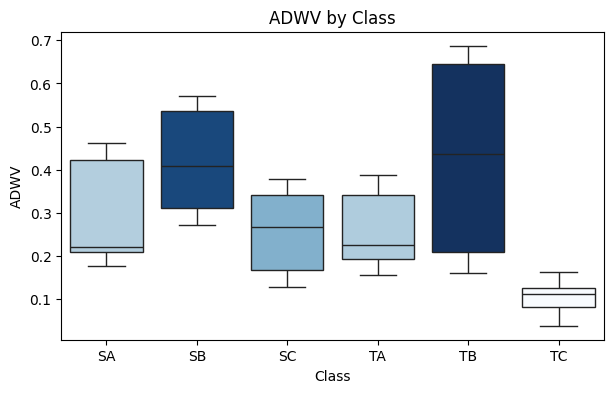

In [32]:
medians_adwv = greenhouse.groupby("Class")["ADWV"].median()

norm_adwv = plt.Normalize(medians_adwv.min(), medians_adwv.max())
colors_adwv = cm.Blues(norm_adwv(medians_adwv.values))

palette_adwv = dict(zip(medians_adwv.index, colors_adwv))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='ADWV', data=greenhouse, palette=palette_adwv)
plt.title('ADWV by Class')
plt.xlabel('Class')
plt.ylabel('ADWV')
plt.show()

Insight: `Class` TB have median highest `ADWV` and `Class` TC have median lowest `ADWV`

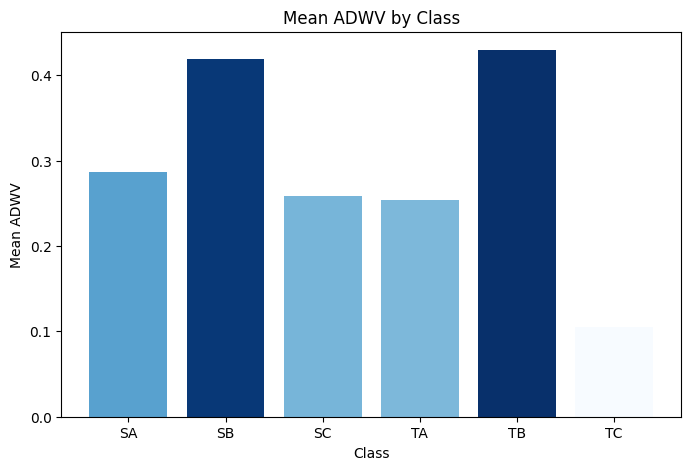

In [33]:
means_adwv = greenhouse.groupby('Class')['ADWV'].mean().reset_index()

norm_adwv = plt.Normalize(means_adwv['ADWV'].min(), means_adwv['ADWV'].max())
colors_adwv = cm.Blues(norm_adwv(means_adwv['ADWV']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_adwv['Class'], means_adwv['ADWV'], color=colors_adwv)
plt.title('Mean ADWV by Class')
plt.ylabel('Mean ADWV')
plt.xlabel('Class')
plt.show()

Insight: `Class` TB have mean highest `ADWV`

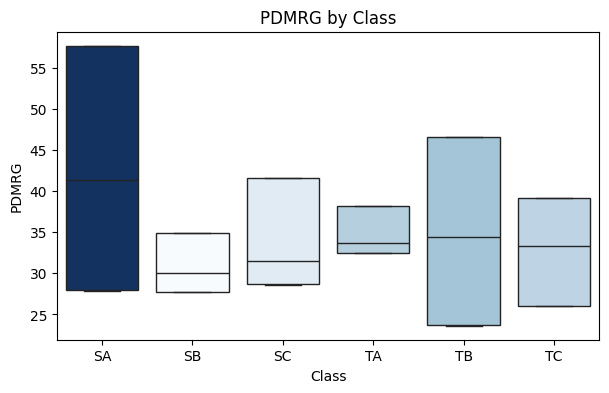

In [34]:
medians_pdmrg = greenhouse.groupby("Class")["PDMRG"].median()

norm_pdmrg = plt.Normalize(medians_pdmrg.min(), medians_pdmrg.max())
colors_pdmrg = cm.Blues(norm_pdmrg(medians_pdmrg.values))

palette_pdmrg = dict(zip(medians_pdmrg.index, colors_pdmrg))

plt.figure(figsize=(7, 4))
sns.boxplot(x='Class', y='PDMRG', data=greenhouse, palette=palette_pdmrg)
plt.title('PDMRG by Class')
plt.xlabel('Class')
plt.ylabel('PDMRG')
plt.show()

Insight: `Class` SA have median highest `PDMRG` and `Class` SB have median lowest `PDMRG`

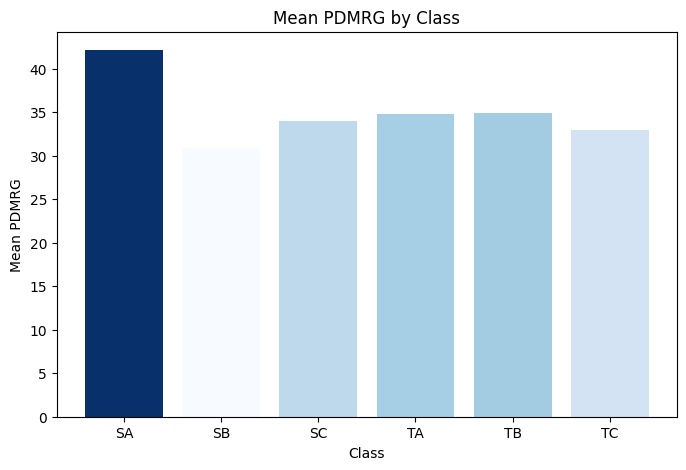

In [35]:
means_pdmrg = greenhouse.groupby('Class')['PDMRG'].mean().reset_index()

norm_pdmrg = plt.Normalize(means_pdmrg['PDMRG'].min(), means_pdmrg['PDMRG'].max())
colors_pdmrg = cm.Blues(norm_pdmrg(means_pdmrg['PDMRG']))

plt.figure(figsize=(8, 5))
bars = plt.bar(means_pdmrg['Class'], means_pdmrg['PDMRG'], color=colors_pdmrg)
plt.title('Mean PDMRG by Class')
plt.ylabel('Mean PDMRG')
plt.xlabel('Class')
plt.show()

Insight: `Class` SA have mean highest `PDMRG`

## Feature Engineering
Feature Engineering is the process of transforming raw data into meaningful features that improve the performance of a machine learning model. It involves creating new features, selecting the most relevant ones, and modifying existing ones to better represent patterns in the data

In [36]:
greenhouse['veg_dry_to_wet_ratio'] = greenhouse['ADWV'] / greenhouse['AWWGV']
greenhouse['root_dry_to_wet_ratio'] = greenhouse['ADWR'] / greenhouse['AWWR']
greenhouse['leaf_area_per_leaf'] = greenhouse['ALAP'] / greenhouse['ANPL']
greenhouse['root_density'] = greenhouse['ADWR'] / (greenhouse['ARL'] * greenhouse['ARD'])
greenhouse['growth_per_leaf_area'] = greenhouse['PHR'] / greenhouse['ALAP']
greenhouse['growth_per_biomass'] = greenhouse['PHR'] / (greenhouse['AWWGV'] + greenhouse['AWWR'])
greenhouse['total_wet_biomass'] = greenhouse['AWWGV'] + greenhouse['AWWR']
greenhouse['total_dry_biomass'] = greenhouse['ADWV'] + greenhouse['ADWR']
greenhouse['overall_dry_ratio'] = greenhouse['total_dry_biomass'] / greenhouse['total_wet_biomass']
greenhouse['chlorophyll_per_leaf_area'] = greenhouse['ACHP'] / greenhouse['ALAP']
greenhouse['chlorophyll_per_biomass'] = greenhouse['ACHP'] / greenhouse['total_wet_biomass']

## Preparation Data
Use feature and change data type object to encoding

In [37]:
greenhouse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Random                     30000 non-null  object 
 1   ACHP                       30000 non-null  float64
 2   PHR                        30000 non-null  float64
 3   AWWGV                      30000 non-null  float64
 4   ALAP                       30000 non-null  float64
 5   ANPL                       30000 non-null  float64
 6   ARD                        30000 non-null  float64
 7   ADWR                       30000 non-null  float64
 8   PDMVG                      30000 non-null  float64
 9   ARL                        30000 non-null  float64
 10  AWWR                       30000 non-null  float64
 11  ADWV                       30000 non-null  float64
 12  PDMRG                      30000 non-null  float64
 13  Class                      30000 non-null  obj

In [38]:
greenhouse['Class'].value_counts()

,count
Class,
SA,5000
SB,5000
SC,5000
TA,5000
TB,5000
TC,5000


In [39]:
numeric_columns = [
    'ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD','ADWR', 'PDMVG','ARL', 'AWWR','ADWV', 'PDMRG',
    'veg_dry_to_wet_ratio', 'root_dry_to_wet_ratio','leaf_area_per_leaf', 'root_density',
    'growth_per_leaf_area', 'growth_per_biomass', 'total_wet_biomass', 'total_dry_biomass',
    'overall_dry_ratio', 'chlorophyll_per_leaf_area', 'chlorophyll_per_biomass'
]

scaler = StandardScaler()

greenhouse[numeric_columns] = scaler.fit_transform(greenhouse[numeric_columns])

In [40]:
categorical_cols = greenhouse.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    greenhouse[col] = label_encoder.fit_transform(greenhouse[col])

Sparate feature and target

In [41]:
x = greenhouse.drop('Class', axis=1)
y = greenhouse['Class']

In [42]:
y.value_counts()

,count
Class,
0,5000
1,5000
2,5000
3,5000
4,5000
5,5000


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=101)

## Modeling
In this phase, we develop and fine-tune machine learning models using powerful algorithms like XGBoost. With Python’s Xgboost, we train models, optimize hyperparameters, and evaluate their performance. The goal: a model that balances accuracy, precision, and recall to deliver actionable insights. Before modeling applied, split data train and data validation to train model

In [45]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=6,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# train model
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=6, num_parallel_tree=None, ...)

<Figure size 1000x600 with 0 Axes>

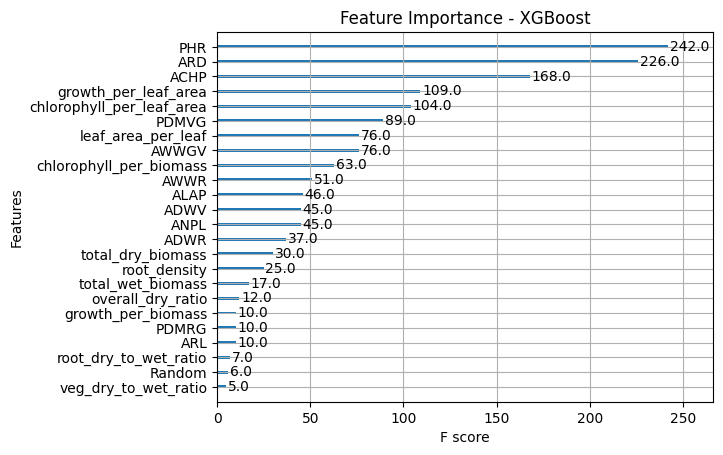

In [46]:
# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight')
plt.title("Feature Importance - XGBoost")
plt.show()

Insight: `PHR` have highest value feature importance

100%|===================| 35882/36000 [03:25<00:00]       

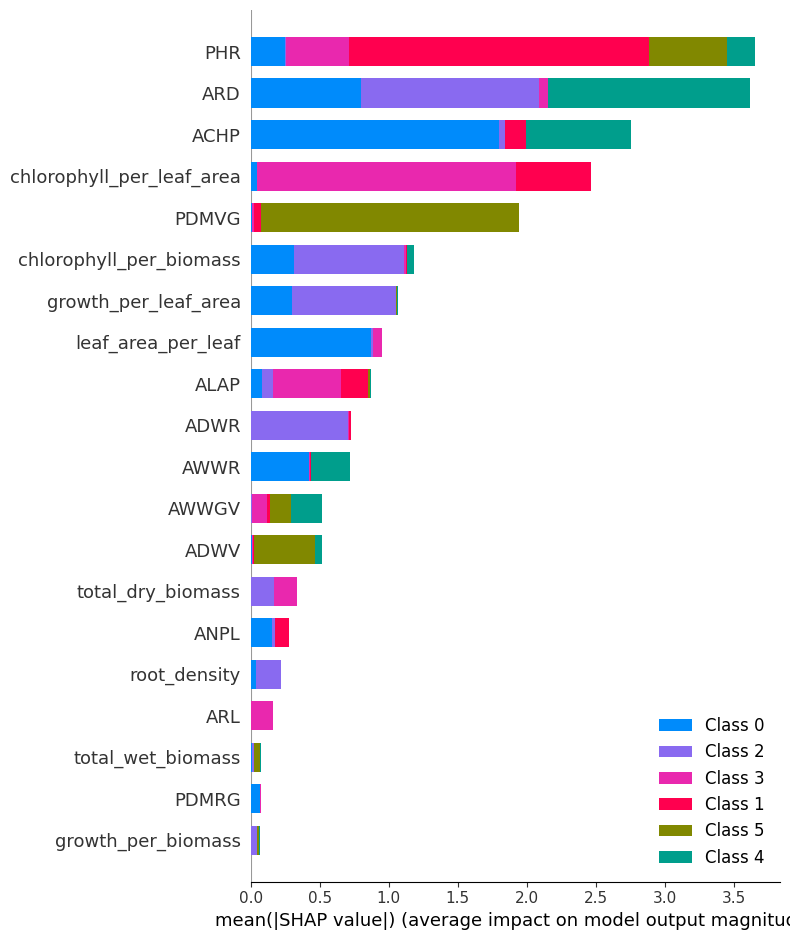

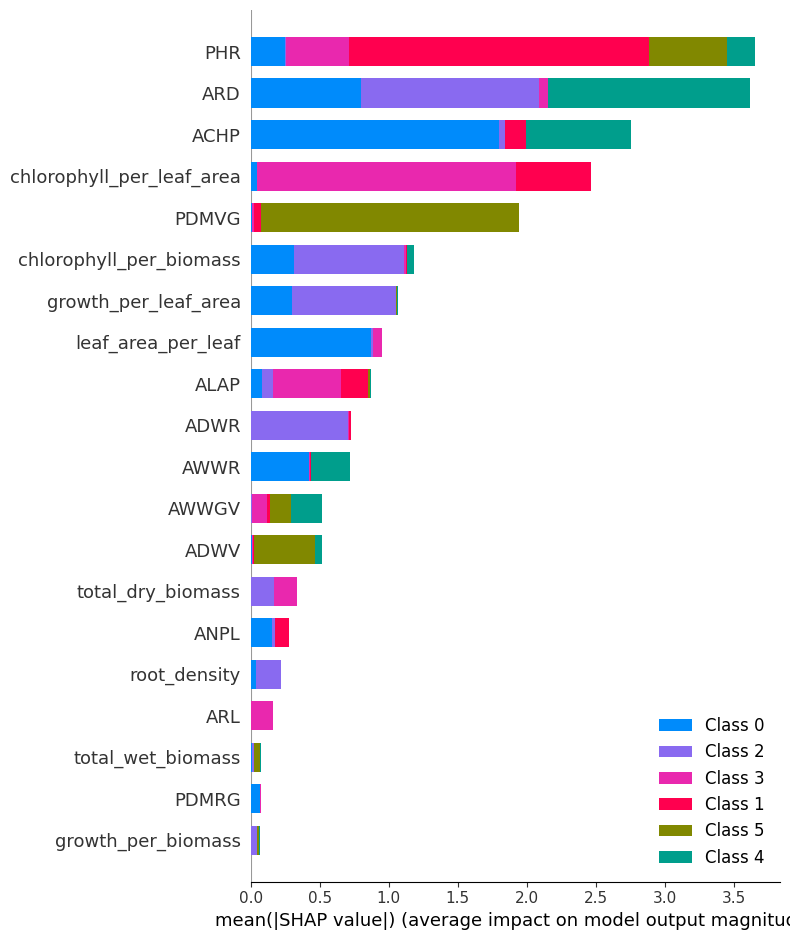

In [50]:
# Make explainer
explainer = shap.Explainer(model, X_train)

# Calculation SHAP values (multi-class: output-nya list)
shap_values = explainer(X_test)

# SHAP Summary Plot (All class merge)
shap.summary_plot(shap_values, X_test)

# SHAP Summary Bar Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

Insight: colour dominan in every feature show `Class` Type

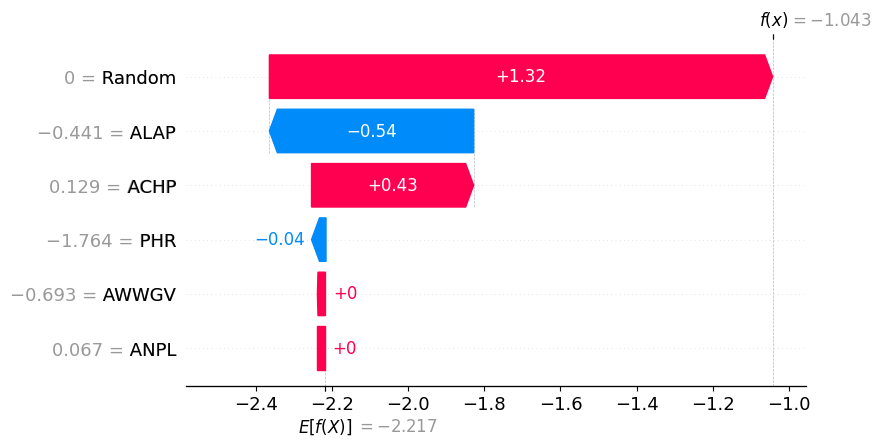

In [52]:
# SHAP waterfall for 1 sample and 1 class
sample_index = 1
class_index = 0  # Change according to the target label you want to analyze (0 to 5)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[class_index].values[sample_index],
        base_values=shap_values[class_index].base_values[sample_index],
        data=X_test.iloc[sample_index],
        feature_names=X_test.columns
    )
)

Insight: colour red to right increase prediction and colour blue to left decrease value prediction

## Prediction & Evaluation

In [53]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       978
           1       1.00      1.00      1.00       992
           2       1.00      1.00      1.00      1020
           3       1.00      1.00      1.00       999
           4       1.00      1.00      1.00       990
           5       1.00      1.00      1.00      1021

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



Confusion Matrix:
[[ 978    0    0    0    0    0]
 [   0  992    0    0    0    0]
 [   0    0 1020    0    0    0]
 [   0    0    0  999    0    0]
 [   0    0    0    0  990    0]
 [   0    0    0    0    0 1021]]


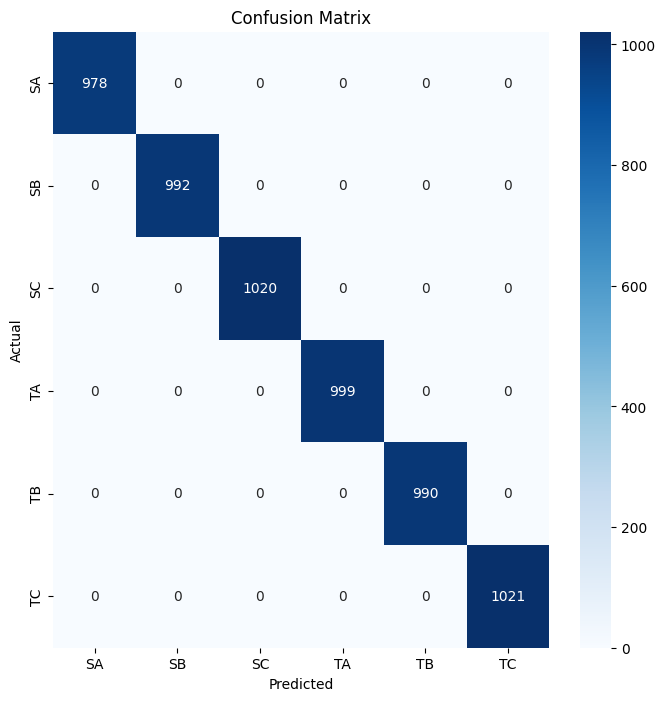

In [55]:
label_names = ['SA', 'SB', 'SC', 'TA', 'TB', 'TC']

labels_order = [0, 1, 2, 3, 4, 5]

cm = confusion_matrix(y_test, y_pred, labels=labels_order)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

Feature importance highest is `PHR`, model XGBoost with highest accuray is 100%

## Reference

 1. https://scikit-learn.org/stable
 2. https://xgboost.readthedocs.io/en/stable/

## Contact

[Linkedin](http://linkedin.com/in/muh-amri-sidiq)